## Importing necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression , Ridge , Lasso
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error,r2_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import qqplot
from sklearn.preprocessing import StandardScaler
import warnings 
warnings.filterwarnings('ignore')

## Imoprt the data set.

In [57]:
df = pd.read_csv('data/cleaned_data.csv',index_col=0)
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


### we will choose the math score to be our target variable

<Axes: >

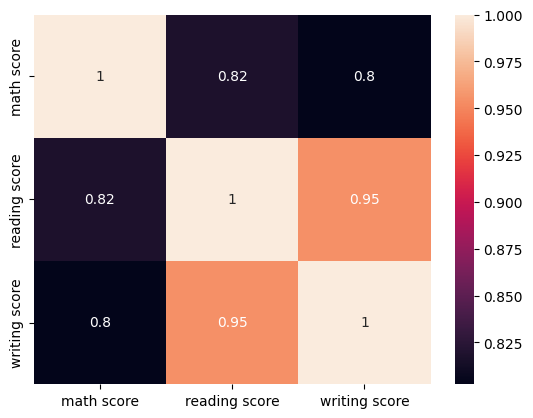

In [58]:
sns.heatmap(df[['math score','reading score','writing score']].corr(),annot=True)

## We can see that reading and writing scores have high corr , we should drop one of them to prevent multi collinearity , the optimal choice will be to drop the writing score because it has less corr with the target variable

### let's make X , Y variabels.

In [59]:
X = df.drop(columns=['math score','writing score'])
y  = df['math score']

In [60]:
X.shape , y.shape

((1000, 6), (1000,))

### Splitting the data into train and test split

In [61]:
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [62]:
X_train.shape , X_test.shape , y_train.shape , y_test.shape

((800, 6), (200, 6), (800,), (200,))

### Feature engineering
- Standard scaling.
- OneHotEncoding.
- Ordinal Encoding for features with ranking type of categorical features.
- Columns transformer as our pipeline. 

In [63]:
num_features = X.select_dtypes(exclude='object').columns
num_features

Index(['reading score'], dtype='object')

In [ ]:
sc = StandardScaler()
ohe_columns = ['gender','race/ethnicity','lunch','test preparation course']
oe_columns = ['parental level of education']
custom_order = [['high school','some college','associate\'s degree','bachelor\'s degree','master\'s degree']]
ohe = OneHotEncoder(drop='first')
oe = OrdinalEncoder(categories=custom_order)
preprocessor = ColumnTransformer([('OneHotEncoder',ohe,ohe_columns),
                                  ('OrdinalEncoder',oe,oe_columns),
                                  ('standatdScaler',sc,num_features)])

In [65]:
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

In [66]:
X_train_scaled.shape , X_test_scaled.shape

((800, 9), (200, 9))

### Model training and evaluation and hyper parameter tuning

#### Caclulating adjusted R2
- adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - k - 1))
- n = Number of observations
- k = Number of predictors

In [ ]:
# random_forest_params  = {
#     'n_estimators': [100, 300, 500],
#     'max_depth': [None, 10, 20, 30], 
#     'min_samples_split': [2, 5, 10],  
#     'min_samples_leaf': [1, 2, 4],  
#     'max_features': [ 'sqrt', 'log2'], 
#     'bootstrap': [True, False] 
# }
# GBR_param_grid = {
#     'n_estimators': [100, 300, 500],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'max_depth': [3, 5, 7, 10], 
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'subsample': [0.6, 0.8, 1.0],
#     'max_features': ['auto', 'sqrt', 'log2'],
# }
# XGBRegressor_param_grid = {
#     'n_estimators': [100, 300, 500],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],  
#     'max_depth': [3, 5, 7, 10],  
#     'min_child_weight': [1, 3, 5], 
#     'subsample': [0.6, 0.8, 1.0],  
#     'colsample_bytree': [0.6, 0.8, 1.0], 
#     'gamma': [0, 0.1, 0.2, 0.5], 
#     'reg_alpha': [0, 0.01, 0.1, 1], 
#     'reg_lambda': [0, 0.01, 0.1, 1]  
# }
# cv_models = [('RandomForest',RandomForestRegressor(),random_forest_params),
#              ('XGBRegressor',XGBRegressor(),XGBRegressor_param_grid),
#              ('GradientBoostingRegressor',GradientBoostingRegressor(),GBR_param_grid)]
# for model_name , model , param in cv_models:
#     cv = RandomizedSearchCV(model,param,
#     n_iter=100,n_jobs=-1,refit='r2',verbose=2)
#     cv.fit(X_train_scaled,y_train)
#     print(f'{model_name} best params : {cv.best_params_}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
RandomForest best params : {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 20, 'bootstrap': True}
Fitting 5 folds for each of 100 candidates, totalling 500 fits
XGBRegressor best params : {'subsample': 0.6, 'reg_lambda': 0.1, 'reg_alpha': 0, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.8}
Fitting 5 folds for each of 100 candidates, totalling 500 fits
GradientBoostingRegressor best params : {'subsample': 0.8, 'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 3, 'learning_rate': 0.05}


In [78]:
from sklearn.model_selection import cross_val_score
models = {'RandomForest':RandomForestRegressor(n_estimators= 300, min_samples_split= 2, min_samples_leaf= 2, max_features= 'log2', max_depth= 20, bootstrap=True),
         'DecisionTree':DecisionTreeRegressor(),
         'Linear':LinearRegression(),
         'Ridge':Ridge(),
         'Lasso':Lasso(),
         'XGBRegressor':XGBRegressor(subsample= 0.6, reg_lambda= 0.1, reg_alpha= 0, n_estimators= 500,
                      min_child_weight=5, max_depth=3, learning_rate= 0.01, gamma= 0.5, colsample_bytree= 0.8),
         'GradientBoostingRegressor':GradientBoostingRegressor(learning_rate=0.05, max_features='log2',
                          min_samples_leaf=4, min_samples_split=10,max_depth=3,
                          n_estimators=300, subsample=0.8)}
results = pd.DataFrame()
for i in range(len(models)):
    model = list(models.values())[i]
    model.fit(X_train_scaled,y_train)
    #Training set Metrics.
    y_train_pred = model.predict(X_train_scaled)
    model_train_MAE = mean_absolute_error(y_train,y_train_pred)
    model_train_r2 = r2_score(y_train,y_train_pred)
    model_train_adjusted_r2 = 1 - ((1 - model_train_r2) * (X_train_scaled.shape[0] - 1) / (X_train_scaled.shape[0] - X_train_scaled.shape[1] - 1))
    #Test set Metrics.
    y_test_pred = model.predict(X_test_scaled)
    model_test_MAE = mean_absolute_error(y_test,y_test_pred)
    model_test_r2 = r2_score(y_test,y_test_pred)
    model_test_adjusted_r2 = 1 - ((1 - model_test_r2) * (X_test_scaled.shape[0] - 1) / (X_test_scaled.shape[0] - X_test_scaled.shape[1] - 1))
    #Results
    results = pd.concat([results,pd.DataFrame([{
        'Model': list(models.keys())[i],
        'Train MAE': model_train_MAE,
        'Train r2': model_train_r2,
        'Train adjusted r2':model_train_adjusted_r2,
        'test MAE': model_test_MAE,
        'test r2': model_test_r2,
        'test adjusted r2':model_test_adjusted_r2,
    }])],ignore_index=True)

In [79]:
results

,Model,Train MAE,Train r2,Train adjusted r2,test MAE,test r2,test adjusted r2
0,RandomForest,3.724377,0.902171,0.901057,5.492154,0.789400,0.779425
1,DecisionTree,0.450833,0.988978,0.988852,7.153333,0.673618,0.658157
2,Linear,4.805201,0.839592,0.837765,4.737006,0.852674,0.845695
3,Ridge,4.803580,0.839581,0.837753,4.735084,0.852522,0.845536
4,Lasso,5.524317,0.784438,0.781982,5.460806,0.806730,0.797575
5,XGBRegressor,4.598298,0.853374,0.851703,4.829004,0.839592,0.831993
6,GradientBoostingRegressor,4.280047,0.871052,0.869583,5.034717,0.831708,0.823737


### we can see the our optimal model is the LinearRegression with test adjusted r2 of 84.56%

In [70]:
lr = LinearRegression()
lr.fit(X_train_scaled,y_train)
y_pred = lr.predict(X_test_scaled)

In [71]:
r2_score(y_test,y_pred)

0.8526735315096998

In [72]:
1 - ((1 - r2_score(y_test,y_pred)) * (X_train_scaled.shape[0] - 1) / (X_train_scaled.shape[0] - X_train_scaled.shape[1] - 1))

0.8509951287041141

### Now let's check for linear regression assumptions
1. linearity.
2. independece.
3. homoscedasticity.
4. normality of residuals.
5. no multicollinearity.

<Axes: ylabel='math score'>

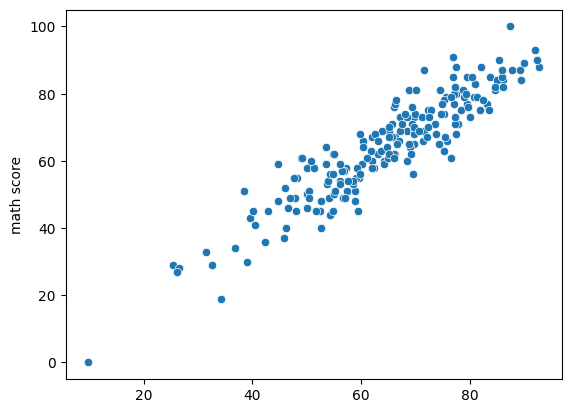

In [73]:
sns.scatterplot(x=y_pred,y=y_test)

In [74]:
residuals = y_test - y_pred

<Axes: xlabel='math score', ylabel='Count'>

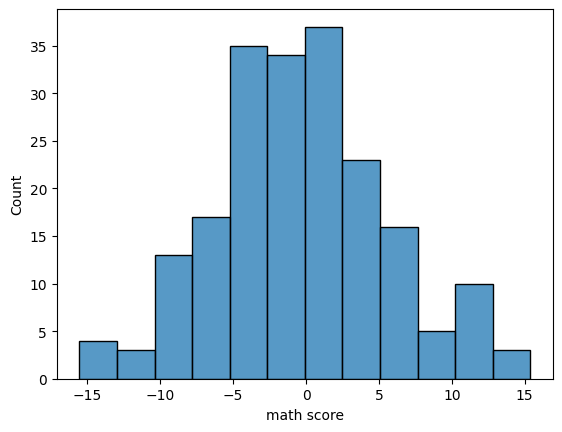

In [75]:
sns.histplot(residuals)

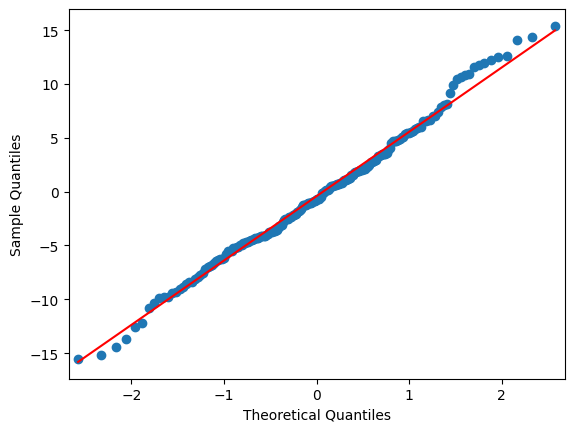

In [76]:
qqplot(residuals,line='s')
print()

- VIF < 5 → No multicollinearity
- VIF between 5-10 → Moderate multicollinearity 
- VIF > 10 → High multicollinearity  (Feature should likely be removed or transformed)

In [77]:
X_train_vif = pd.DataFrame(X_train_scaled).copy()
X_train_vif.insert(0, 'Intercept', 1)
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_vif.values, i) for i in range(X_train_vif.shape[1])]
print(vif_data)


     Feature        VIF
0  Intercept  17.358864
1          0   1.101186
2          1   2.631881
3          2   3.276702
4          3   2.984421
5          4   2.340768
6          5   1.082624
7          6   1.097091
8          7   1.048368
9          8   1.304724


<Axes: xlabel='math score'>

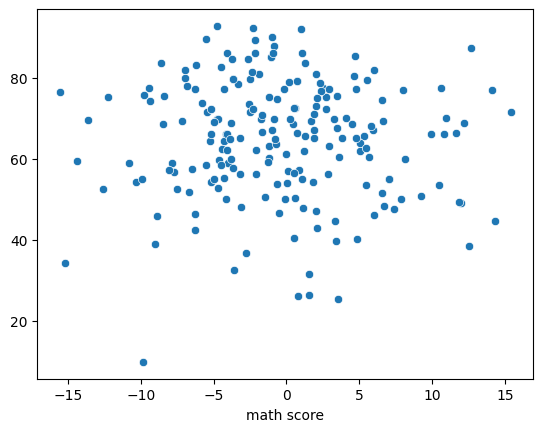

In [82]:
sns.scatterplot(x=residuals,y=y_pred)

# We can see that our Assumptions are successfully met